In [ ]:
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # For formatting x-axis with years
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
def load_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, auto_adjust=False)

    if data.empty:
        print(f"Error: No data retrieved for {ticker}. Check API availability.")
        sys.exit(1)  # Stop the script if data is missing

    data.reset_index(inplace=True)
    return data
def create_sequences(X, y, dates, time_steps):
    X_seq, y_seq, date_seq = [], [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
        date_seq.append(dates[i + time_steps])  # Store corresponding date
    return np.array(X_seq), np.array(y_seq), np.array(date_seq)


In [ ]:
def prepare_data(main_ticker, tickers, start_date, end_date):
    """
    Loads financial data from Yahoo Finance, calculates technical indicators,
    and prepares the dataset for modeling.

    Parameters:
        main_ticker (str): The main stock/index ticker (e.g., "^GSPC").
        tickers (list of str): List of additional tickers (e.g., ["AAPL", "MSFT", ...]).
        start_date (str): Start date for data collection (YYYY-MM-DD).
        end_date (str): End date for data collection (YYYY-MM-DD).

    Returns:
        pd.DataFrame: Processed dataset with selected tickers, technical indicators, and the target variable.
    """
    # Load data for additional tickers
    data = load_data(tickers, start_date, end_date)

    # Load data for the main ticker (^GSPC)
    main_data = load_data(main_ticker, start_date, end_date)

    # Create target variable (shifted Adj Close to predict next day's price)
    main_data["Target"] = main_data["Adj Close"].shift(-1)

    # Extract only the Adj Close prices of the selected tickers
    data_adj_close = data["Adj Close"]

    # Merge additional tickers' Adj Close into main_data
    for ticker in tickers:
        main_data[ticker] = data_adj_close[ticker]


    # --- Technical Indicators ---

    # Simple Moving Averages (SMA)
    main_data['SMA10'] = main_data['Adj Close'].rolling(window=10).mean()
    main_data['SMA50'] = main_data['Adj Close'].rolling(window=50).mean()


    delta = main_data['Adj Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14, min_periods=14).mean()
    avg_loss = loss.rolling(window=14, min_periods=14).mean()
    rs = avg_gain / avg_loss
    main_data['RSI'] = 100 - (100 / (1 + rs))

    main_data['EMA12'] = main_data['Adj Close'].ewm(span=12, adjust=False).mean()
    main_data['EMA26'] = main_data['Adj Close'].ewm(span=26, adjust=False).mean()
    main_data['MACD'] = main_data['EMA12'] - main_data['EMA26']

    main_data['Returns'] = main_data['Adj Close'].pct_change()
    main_data['Volatility'] = main_data['Returns'].rolling(window=20).std()

    main_data.dropna(inplace=True)

    return main_data

In [ ]:


def select_top_features_rfe(data, n_features, target_column_contains="Adj Close", test_size=0.2, random_state=42):
    """
    Normalizes the data and performs RFE to select the top features.

    Parameters:
    - data: pandas DataFrame returned by prepare_data(...)
    - target_column_contains: string to identify target column (default "Adj Close")
    - n_features: number of top features to select (default 10)
    - test_size: fraction of data to use for testing (default 0.2)
    - random_state: seed for reproducibility

    Returns:
    - selected_features: list of selected feature names
    """

    # Flatten MultiIndex columns if needed
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = ['_'.join(col).strip() for col in data.columns.values]

    # Find target column
    target_col = next((col for col in data.columns if target_column_contains in col), None)
    if not target_col:
        raise KeyError(f"Could not find target column containing '{target_column_contains}'.")

    # Prepare X and y
    X = data.drop(columns=[target_col], errors="ignore").select_dtypes(include=["number"])
    y = data[target_col].values.ravel()

    # Normalize
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

    # Train-test split (no shuffle for time series)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=test_size, random_state=random_state, shuffle=False
    )

    # RFE with RandomForest
    model = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)

    selected_features = np.array(X.columns)[rfe.support_]
    return selected_features.tolist()

In [ ]:
def train_lstm_model(data, selected_features, time_steps=90, test_size=0.2, epochs=100, batch_size=32, learning_rate=0.001):


    X_raw = data[selected_features].values
    target_col = next((col for col in data.columns if "Target" in col), None)
    if target_col is None:
        raise KeyError("Could not find 'Target' in data. Check available columns.")


    # Extract features and target
    y_raw = data[target_col].values.reshape(-1, 1)

    # Normalize features
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw)

    # Normalize target variable
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_raw.reshape(-1, 1)).ravel()


    # Convert date column if available
    date_col = next((col for col in data.columns if "Date" in col), None)
    if date_col:
        data[date_col] = pd.to_datetime(data[date_col])
        X_seq, y_seq, dates_seq = create_sequences(X_scaled, y_scaled, data[date_col].values, time_steps)
    else:
        raise KeyError("Could not find 'Date' column in data. Check available columns.")



    # Split into training and test sets
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X_seq, y_seq, dates_seq, test_size=test_size, random_state=42, shuffle=False
    )

    # Define LSTM model
    model = Sequential([
        Input(shape=(time_steps,  len(selected_features))),
        LSTM(64, return_sequences=True, activation='tanh'),
        LSTM(32, return_sequences=False, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Early Stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[early_stop]
    )

    # Generate predictions
    y_pred = model.predict(X_test)



    return model, y_pred, y_test, scaler_X, scaler_y, dates_test

In [ ]:
def run_trading_strategy(y_pred_actual, y_test_actual, threshold=0.005, initial_capital=1000):
    """
    Executes a long/short trading strategy based on predicted vs. actual prices,
    only trading when the predicted change exceeds the specified threshold.

    Parameters:
        y_pred_actual (np.ndarray): Model's predicted prices (scaled back).
        y_test_actual (np.ndarray): Actual prices (scaled back).
        threshold (float): Minimum predicted change to trigger a trade (default: 0.005 = 0.5%).
        initial_capital (float): Starting capital (default: $1000).

    Returns:
        portfolio (list): Capital progression over time.
        final_return (float): Percentage return on the strategy.
        accuracy (float): Correct trend prediction accuracy.
        total_trades (int): Total number of trades made.
    """
    capital = initial_capital
    portfolio = []
    correct_trend_preds = 0
    total_trades = 0

    for i in range(1, len(y_pred_actual)):
        pred_today = y_pred_actual[i - 1][0]
        pred_tomorrow = y_pred_actual[i][0]
        price_today = y_test_actual[i - 1][0]
        price_tomorrow = y_test_actual[i][0]

        predicted_change = (pred_tomorrow - pred_today) / pred_today

        if abs(predicted_change) >= threshold:
            trade_amount = capital

            if predicted_change > 0:
                # Long position
                shares = trade_amount / price_today
                capital = shares * price_tomorrow

                if price_tomorrow > price_today:
                    correct_trend_preds += 1

            else:
                # Short position
                shares = trade_amount / price_today
                capital += (price_today - price_tomorrow) * shares

                if price_tomorrow < price_today:
                    correct_trend_preds += 1

            total_trades += 1

        portfolio.append(capital)

    final_return = (capital - initial_capital) / initial_capital * 100
    accuracy = (correct_trend_preds / total_trades * 100) if total_trades else 0

    return portfolio, final_return, accuracy, total_trades

In [ ]:
main_ticker = "^GSPC"
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TSLA", "^IRX", "^VIX", "^TNX"]
TRAIN_START = "2015-01-01"
TRAIN_END = "2025-02-01"

# Get processed data
data = prepare_data(main_ticker, tickers, TRAIN_START, TRAIN_END)
selected_features = select_top_features_rfe(data,10)
print(f"Selected Features: {selected_features}")
model, y_pred, y_test, scaler_X, scaler_y,  dates_test = train_lstm_model(data, selected_features)

y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae_percentage = mean_absolute_percentage_error(y_test_actual, y_pred_actual)


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


Selected Features: ['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Target_', 'AAPL_', 'MSFT_', 'SMA10_', 'EMA12_', 'EMA26_']
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0204 - val_loss: 0.0053
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0013 - val_loss: 0.0045


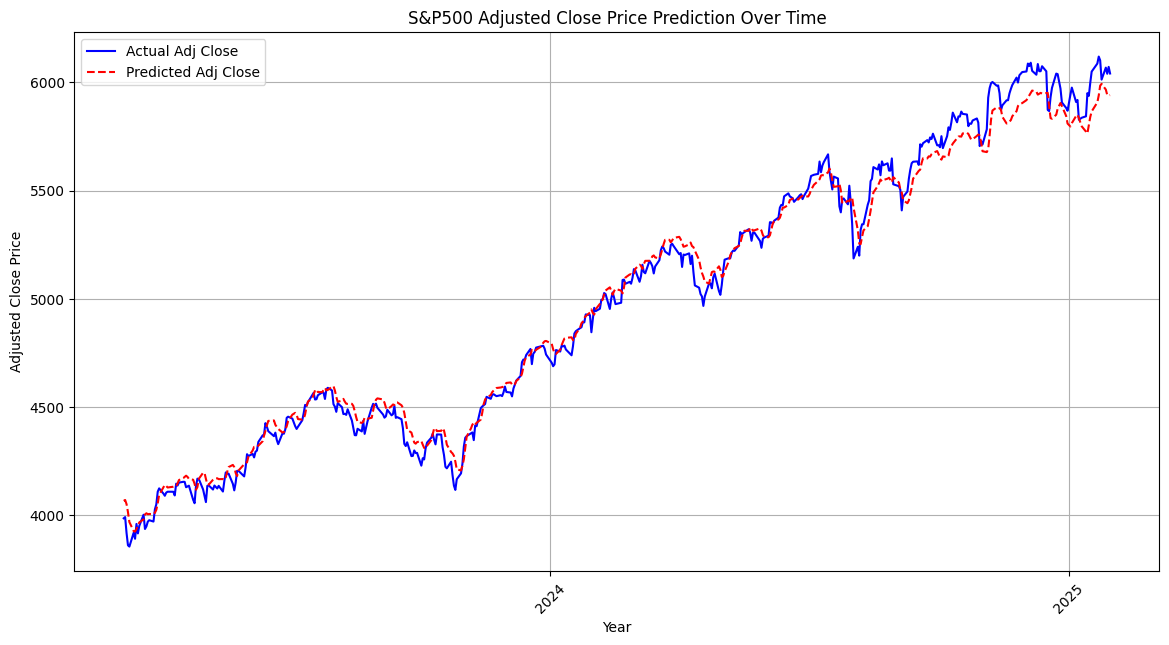

Mean Percentage Error: 0.01065257176329367
🔹 Root Mean Squared Error (RMSE): 70.3789


In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test_actual, label="Actual Adj Close", color="blue")
plt.plot(dates_test, y_pred_actual, label="Predicted Adj Close", color="red", linestyle="dashed")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()

print(f"Mean Percentage Error: {mae_percentage}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")


 Final Return: 7.35%
 Accuracy: 59.09%
 Trades Made: 110


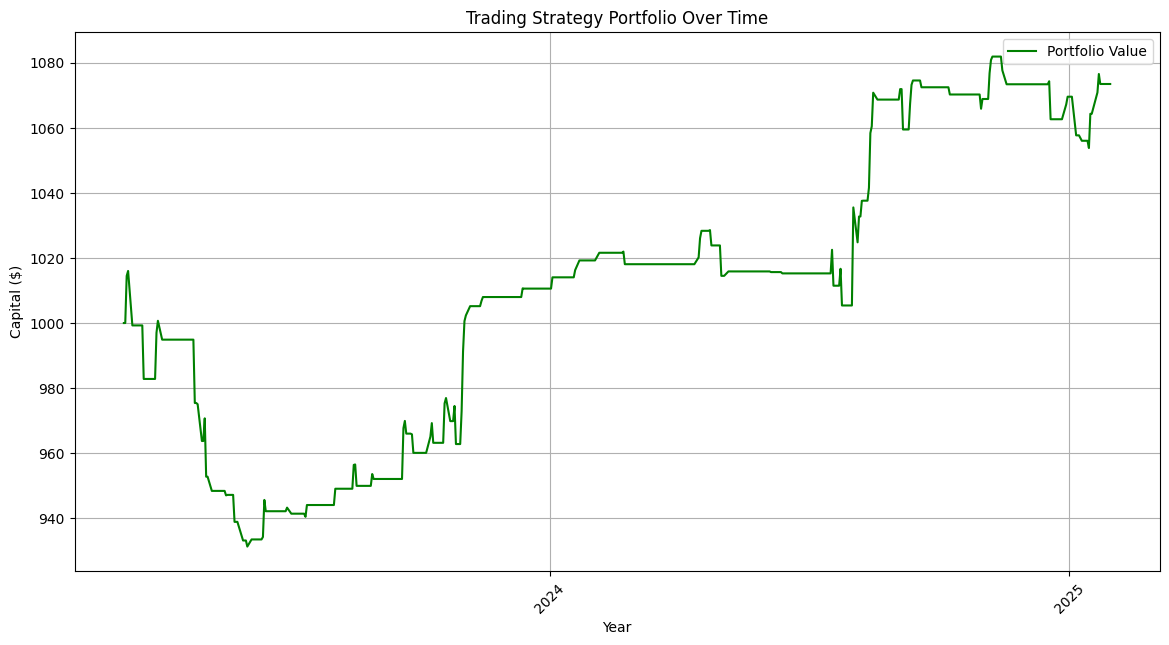

In [ ]:
portfolio, final_return, accuracy, trades = run_trading_strategy(y_pred_actual, y_test_actual)

print(f" Final Return: {final_return:.2f}%")
print(f" Accuracy: {accuracy:.2f}%")
print(f" Trades Made: {trades}")

plt.figure(figsize=(14, 7))
portfolio_padded = np.insert(portfolio, 0, np.nan)  # or 100.0 as starting capital
plt.plot(dates_test, portfolio_padded, label="Portfolio Value", color="green")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title("Trading Strategy Portfolio Over Time")
plt.xlabel("Year")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.show()




In [ ]:

## section for n=13


selected_features2 = select_top_features_rfe(data,13)
print(f"Selected Features: {selected_features2}")
model, y_pred, y_test, scaler_X, scaler_y,  dates_test = train_lstm_model(data, selected_features2)

mae_scaled = mean_absolute_error(y_test, y_pred)

y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_pred_actual2 = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual2))
mae_percentage = mean_absolute_percentage_error(y_test_actual, y_pred_actual2)

Selected Features: ['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Target_', 'AAPL_', 'MSFT_', 'TSLA_', '^IRX_', '^TNX_', 'SMA10_', 'EMA12_', 'EMA26_']
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0370 - val_loss: 0.0171
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0023 - val_loss: 0.0157
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0020 - val_loss: 0.0092
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0018 - val_loss: 0.0146
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0015 - val_loss: 0.0109
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0014 - val_loss: 0.0100
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0016 - val_loss: 0.0072
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0013 - val_loss: 0.0087
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss

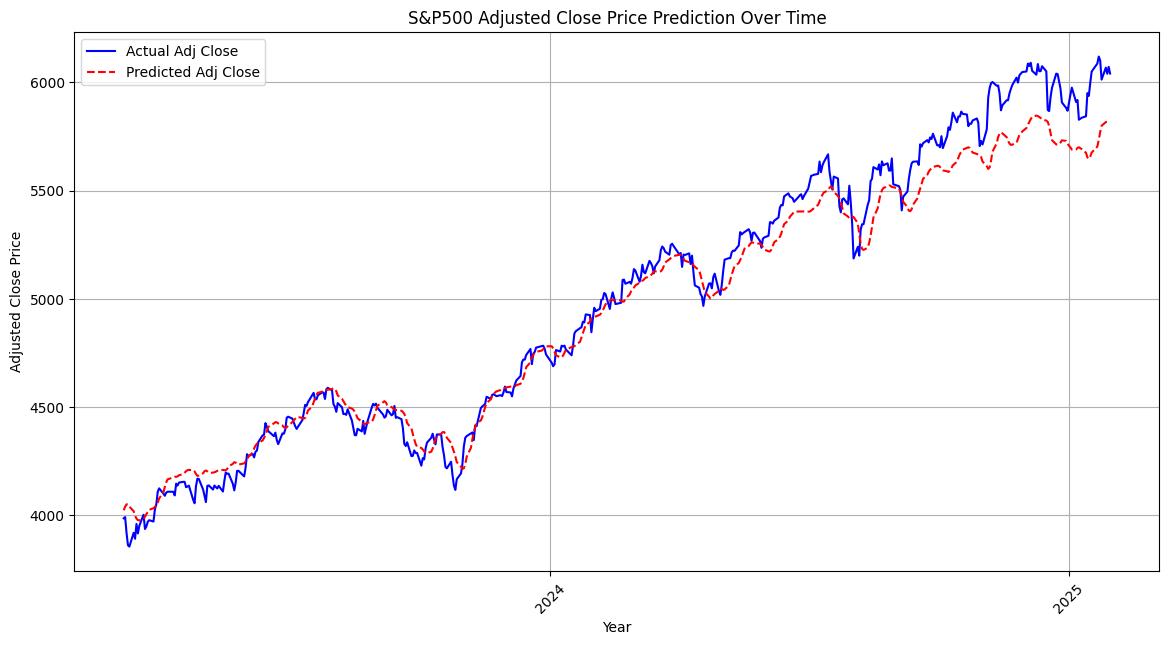

Mean Percentage Error: 0.017174277388612692
🔹 Root Mean Squared Error (RMSE): 119.9025


In [ ]:
mae_percentage = mean_absolute_percentage_error(y_test_actual, y_pred_actual2)
plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test_actual, label="Actual Adj Close", color="blue")
plt.plot(dates_test, y_pred_actual2, label="Predicted Adj Close", color="red", linestyle="dashed")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()

print(f"Mean Percentage Error: {mae_percentage}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")


 Final Return: -5.90%
 Accuracy: 48.94%
 Trades Made: 47


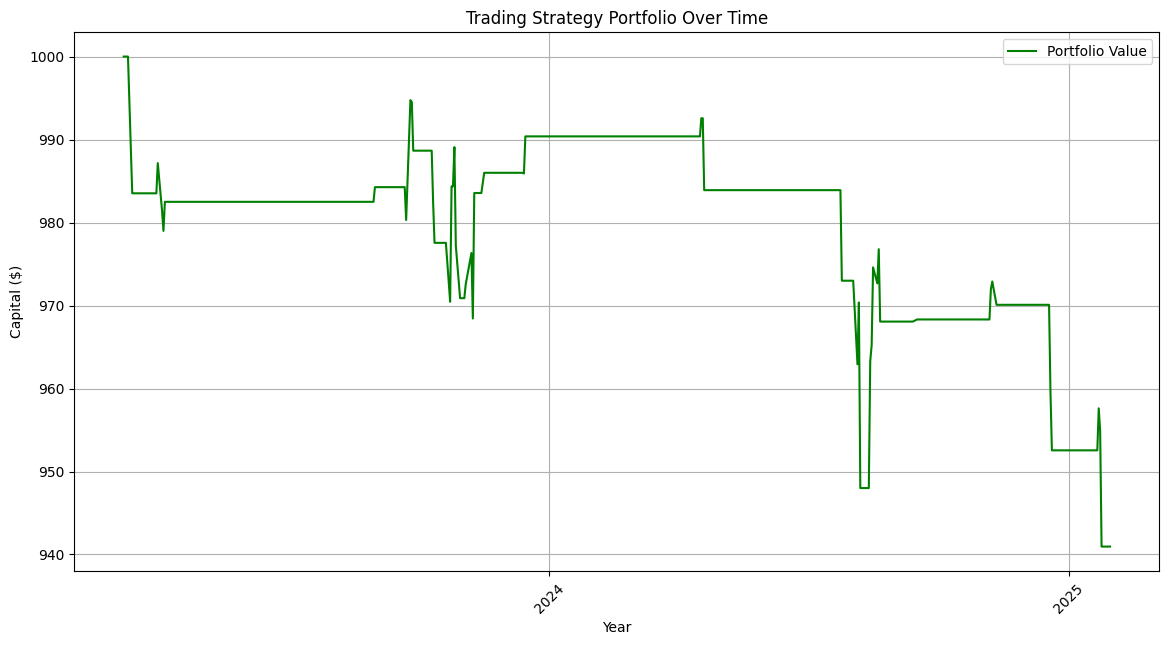

In [ ]:
portfolio, final_return, accuracy, trades = run_trading_strategy(y_pred_actual2, y_test_actual)

print(f" Final Return: {final_return:.2f}%")
print(f" Accuracy: {accuracy:.2f}%")
print(f" Trades Made: {trades}")

plt.figure(figsize=(14, 7))
portfolio_padded = np.insert(portfolio, 0, np.nan)  # or 100.0 as starting capital
plt.plot(dates_test, portfolio_padded, label="Portfolio Value", color="green")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title("Trading Strategy Portfolio Over Time")
plt.xlabel("Year")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.show()




In [ ]:
## section for n= 7

selected_features3 = select_top_features_rfe(data,7)
print(f"Selected Features: {selected_features3}")
model, y_pred, y_test, scaler_X, scaler_y,  dates_test = train_lstm_model(data, selected_features2)

mae_scaled = mean_absolute_error(y_test, y_pred)

y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_pred_actual3= scaler_y.inverse_transform(y_pred.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual3))
mae_percentage = mean_absolute_percentage_error(y_test_actual, y_pred_actual3)

Selected Features: ['Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Target_', 'MSFT_', 'EMA12_', 'EMA26_']
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0242 - val_loss: 0.0286
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0023 - val_loss: 0.0229
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0018 - val_loss: 0.0160
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0018 - val_loss: 0.0130
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0017 - val_loss: 0.0099
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0014 - val_loss: 0.0066
Epoch 11/100
60/60 ━━━━━━━━━━━━━━

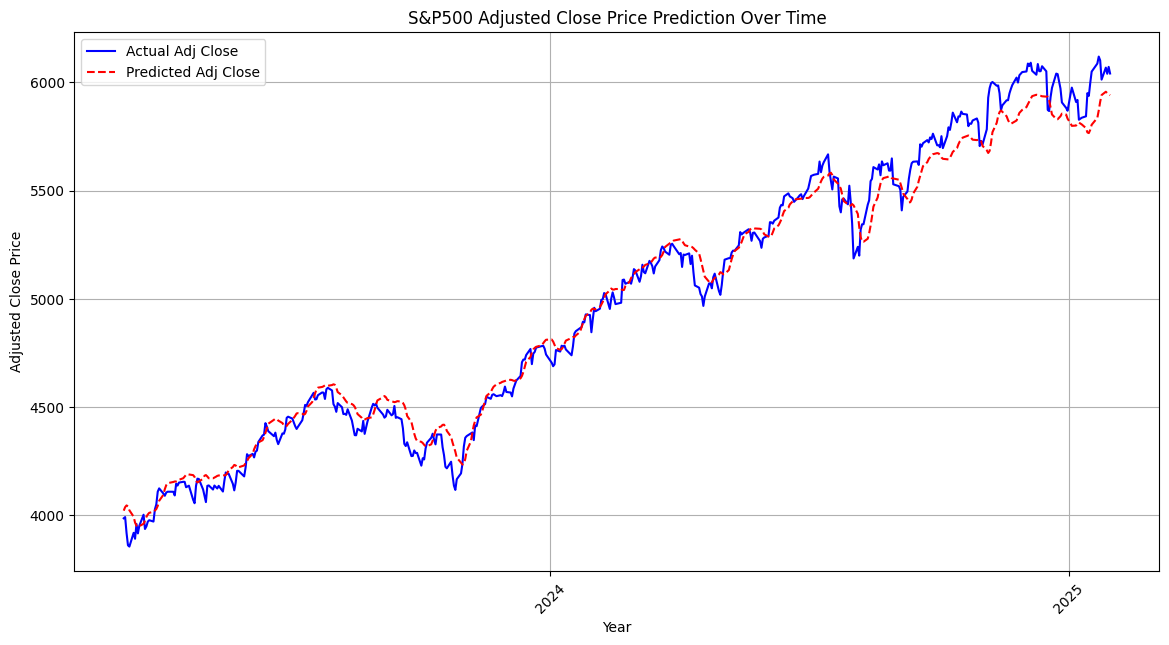

Mean Percentage Error: 0.017292625569843085
🔹 Root Mean Squared Error (RMSE): 121.1426


In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test_actual, label="Actual Adj Close", color="blue")
plt.plot(dates_test, y_pred_actual, label="Predicted Adj Close", color="red", linestyle="dashed")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()

print(f"Mean Percentage Error: {mae_percentage}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")

 Final Return: 1.02%
 Accuracy: 54.55%
 Trades Made: 77


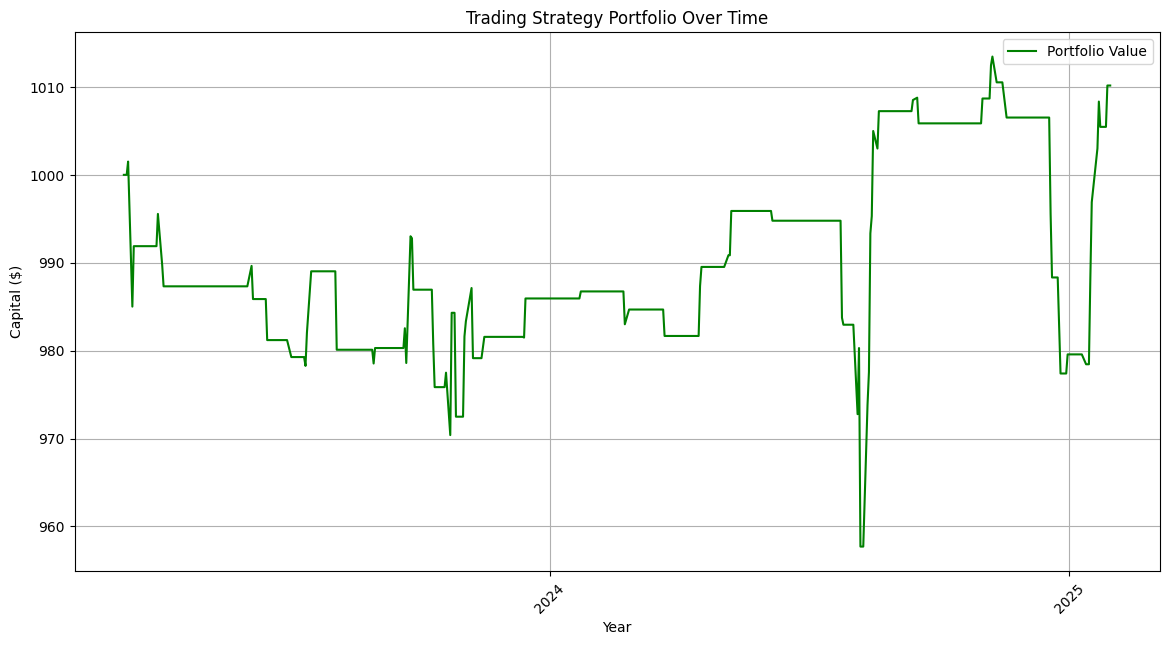

In [ ]:
portfolio, final_return, accuracy, trades = run_trading_strategy(y_pred_actual3, y_test_actual)

print(f" Final Return: {final_return:.2f}%")
print(f" Accuracy: {accuracy:.2f}%")
print(f" Trades Made: {trades}")

plt.figure(figsize=(14, 7))
portfolio_padded = np.insert(portfolio, 0, np.nan)  # or 100.0 as starting capital
plt.plot(dates_test, portfolio_padded, label="Portfolio Value", color="green")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title("Trading Strategy Portfolio Over Time")
plt.xlabel("Year")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.show()


